# Weather prediction with machine learning

## Project intro

In this project, we aim to predict daily weather data (specifically maximum temperature) 
using historical measurements from Oakland International Airport. 

We start by cleaning and exploring the dataset (local_weather.csv), 
focusing on the core variables such as precipitation, temperature, etc. 
We then perform feature engineering, train a Ridge regression model, 
and evaluate our predictions on a test set. Finally, we outline potential improvements, 
including:
- Predicting weather up to a week ahead
- Integrating data from multiple weather stations
- Trying different models (e.g., Random Forest, XGBoost, neural networks)
- Using backtesting to validate future predictions over time.

In [121]:
# Librairies
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

## Loading and exploring the data

In [66]:
# Loading and exploring the dataset
weather = pd.read_csv("data/local_weather.csv", index_col="DATE")
weather

,STATION,NAME,ACMH,ACSH,AWND,DAPR,FMTM,FRGT,MDPR,PGTM,...,WT01,WT02,WT03,WT04,WT05,WT07,WT08,WT09,WT16,WT18
DATE,,,,,,,,,,,,,,,,,,,,,
1960-01-01,USW00023230,"OAKLAND INTERNATIONAL AIRPORT, CA US",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-01-02,USW00023230,"OAKLAND INTERNATIONAL AIRPORT, CA US",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
1960-01-03,USW00023230,"OAKLAND INTERNATIONAL AIRPORT, CA US",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-01-04,USW00023230,"OAKLAND INTERNATIONAL AIRPORT, CA US",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-01-05,USW00023230,"OAKLAND INTERNATIONAL AIRPORT, CA US",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-30,USW00023230,"OAKLAND INTERNATIONAL AIRPORT, CA US",NaN,NaN,4.92,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
2022-01-31,USW00023230,"OAKLAND INTERNATIONAL AIRPORT, CA US",NaN,NaN,3.80,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-01,USW00023230,"OAKLAND INTERNATIONAL AIRPORT, CA US",NaN,NaN,8.95,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Preparing the data

### Data inspection

In [122]:
# We check the proportion of missing values for each column in the dataset
weather.apply(pd.isnull).sum()/weather.shape[0]

STATION    0.000000
NAME       0.000000
ACMH       0.653504
ACSH       0.653504
AWND       0.522175
DAPR       0.999526
FMTM       0.870153
FRGT       0.999881
MDPR       0.999526
PGTM       0.495375
PRCP       0.016661
SNOW       0.325270
SNWD       0.317918
TAVG       0.879224
TMAX       0.000534
TMIN       0.000593
TSUN       0.931756
WDF1       0.653504
WDF2       0.522115
WDF5       0.527274
WDFG       0.747006
WSF1       0.653504
WSF2       0.522056
WSF5       0.527274
WSFG       0.747006
WT01       0.779794
WT02       0.980256
WT03       0.992944
WT04       0.999763
WT05       0.998340
WT07       0.999881
WT08       0.810328
WT09       0.999881
WT16       0.884086
WT18       0.999822
dtype: float64

We see many columns have high percentages of missing values, such as DAPR, MDPR, etc.

In [67]:
# Making a save then renaming columns
core_weather = weather[["PRCP", "SNOW", "SNWD", "TMAX", "TMIN"]].copy()
core_weather.columns = ["precip", "snow", "snow_depth", "temp_max", "temp_min"]

In [68]:
# Check missing values shwoing NaN in each column
core_weather.apply(pd.isnull).sum()

precip         281
snow          5486
snow_depth    5362
temp_max         9
temp_min        10
dtype: int64

### Analysing snow data

In [69]:
core_weather["snow"].value_counts()

snow
0.0    11379
1.0        1
Name: count, dtype: int64

In [70]:
core_weather["snow_depth"].value_counts()

snow_depth
0.0    11504
Name: count, dtype: int64

We drop snow and snow_depth columns since it has low variation (almost always 0.0). Places where snow is rare, so these features don't help much.

In [71]:
del core_weather["snow"]

In [72]:
del core_weather["snow_depth"]

## Handling missing values

We identify rows with missing precipitation values, if these are truly no-precipitation days, we can fill them with 0.0.

In [73]:
core_weather[pd.isnull(core_weather["precip"])]

,precip,temp_max,temp_min
DATE,,,
1983-10-29,NaN,67.0,57.0
1983-10-30,NaN,70.0,63.0
1983-10-31,NaN,69.0,61.0
1983-11-12,NaN,63.0,55.0
1983-11-13,NaN,60.0,50.0
...,...,...,...
2013-12-15,NaN,58.0,33.0
2016-05-01,NaN,80.0,55.0
2016-05-02,NaN,68.0,53.0


In [74]:
core_weather.loc["2013-12-15",:]

precip       NaN
temp_max    58.0
temp_min    33.0
Name: 2013-12-15, dtype: float64

In [75]:
core_weather["precip"].value_counts() / core_weather.shape[0]

precip
0.00    0.810566
0.01    0.025969
0.02    0.011799
0.03    0.007233
0.04    0.006048
          ...   
1.29    0.000059
1.73    0.000059
1.05    0.000059
1.38    0.000059
1.02    0.000059
Name: count, Length: 176, dtype: float64

In [76]:
core_weather["precip"] = core_weather["precip"].fillna(0)

In [77]:
core_weather.apply(pd.isnull).sum()

precip       0
temp_max     9
temp_min    10
dtype: int64

In [78]:
core_weather[pd.isnull(core_weather["temp_min"])]

,precip,temp_max,temp_min
DATE,,,
2004-11-20,0.0,NaN,NaN
2011-12-21,0.0,61.0,NaN
2011-12-22,0.0,62.0,NaN
2011-12-23,0.0,56.0,NaN
2011-12-24,0.0,55.0,NaN
2011-12-25,0.0,54.0,NaN
2013-06-16,0.0,NaN,NaN
2020-08-29,0.0,NaN,NaN
2020-09-08,0.0,NaN,NaN


In [79]:
core_weather.loc["2011-12-18":"2011-12-28"]

,precip,temp_max,temp_min
DATE,,,
2011-12-18,0.0,52.0,33.0
2011-12-19,0.0,55.0,35.0
2011-12-20,0.0,61.0,35.0
2011-12-21,0.0,61.0,NaN
2011-12-22,0.0,62.0,NaN
2011-12-23,0.0,56.0,NaN
2011-12-24,0.0,55.0,NaN
2011-12-25,0.0,54.0,NaN
2011-12-26,0.0,50.0,32.0


In [81]:
core_weather = core_weather.ffill()

In [82]:
core_weather.apply(pd.isnull).sum()

precip      0
temp_max    0
temp_min    0
dtype: int64

In [83]:
core_weather.apply(lambda x: (x == 9999).sum())

precip      0
temp_max    0
temp_min    0
dtype: int64

In [84]:
core_weather.dtypes

precip      float64
temp_max    float64
temp_min    float64
dtype: object

In [85]:
core_weather.index

Index(['1960-01-01', '1960-01-02', '1960-01-03', '1960-01-04', '1960-01-05',
       '1960-01-06', '1960-01-07', '1960-01-08', '1960-01-09', '1960-01-10',
       ...
       '2022-01-25', '2022-01-26', '2022-01-27', '2022-01-28', '2022-01-29',
       '2022-01-30', '2022-01-31', '2022-02-01', '2022-02-02', '2022-02-03'],
      dtype='object', name='DATE', length=16866)

In [86]:
core_weather.index = pd.to_datetime(core_weather.index)

In [87]:
core_weather.index

DatetimeIndex(['1960-01-01', '1960-01-02', '1960-01-03', '1960-01-04',
               '1960-01-05', '1960-01-06', '1960-01-07', '1960-01-08',
               '1960-01-09', '1960-01-10',
               ...
               '2022-01-25', '2022-01-26', '2022-01-27', '2022-01-28',
               '2022-01-29', '2022-01-30', '2022-01-31', '2022-02-01',
               '2022-02-02', '2022-02-03'],
              dtype='datetime64[ns]', name='DATE', length=16866, freq=None)

In [88]:
core_weather.index.year

Index([1960, 1960, 1960, 1960, 1960, 1960, 1960, 1960, 1960, 1960,
       ...
       2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022],
      dtype='int32', name='DATE', length=16866)

## Data analysis

<Axes: xlabel='DATE'>

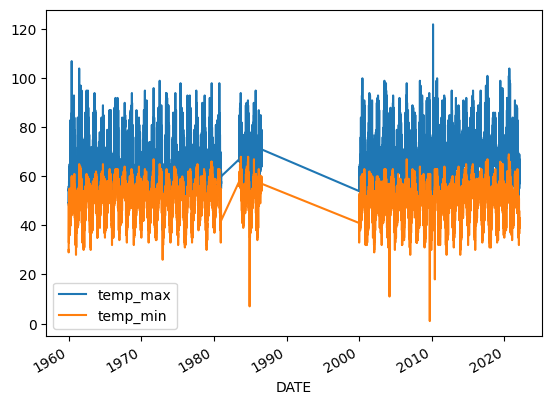

In [89]:
core_weather[["temp_max", "temp_min"]].plot()

We notice some gaps within the years mid-1980s and mid-1990s to early 2000s.

In [90]:
# Checking how many observations exist per year
core_weather.index.year.value_counts().sort_index()

DATE
1960    366
1961    365
1962    365
1963    365
1964    366
1965    365
1966    365
1967    365
1968    366
1969    365
1970    365
1971    365
1972    366
1973    365
1974    365
1975    365
1976    366
1977    365
1978    365
1979    365
1980    366
1983    184
1984    366
1985    365
1986    212
2000    365
2001    365
2002    365
2003    365
2004    366
2005    365
2006    365
2007    365
2008    366
2009    365
2010    365
2011    365
2012    365
2013    365
2014    365
2015    365
2016    366
2017    365
2018    365
2019    365
2020    366
2021    365
2022     34
Name: count, dtype: int64

We notice few years are missing obersvations (e.g. 1980-->1983, 1986-->2000)

<Axes: xlabel='DATE'>

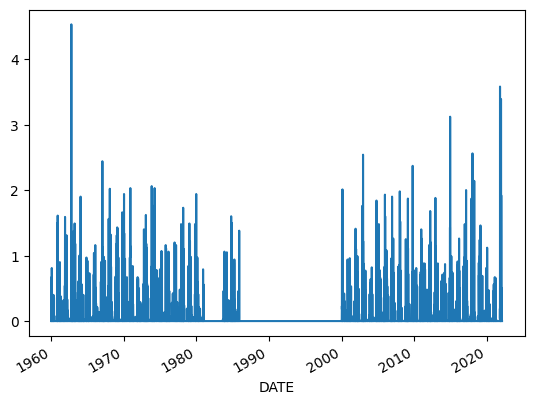

In [91]:
# Checking if precipitations data has odd behaviour
core_weather["precip"].plot()

<Axes: xlabel='DATE'>

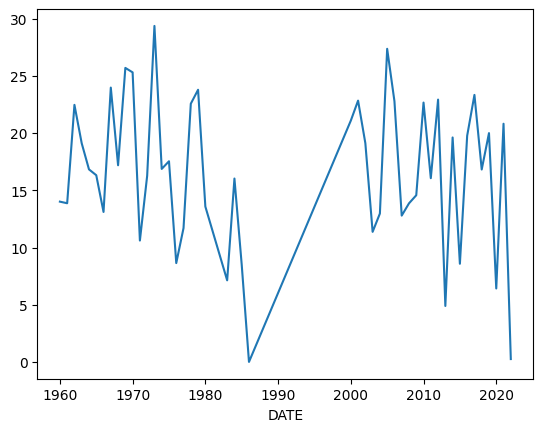

In [92]:
# Checking how much it rained each year
core_weather.groupby(core_weather.index.year).apply(lambda x: x["precip"].sum()).plot()

## Machine learning training

In [93]:
# Creating a column with tomorrow'w temperature
core_weather["target"] = core_weather.shift(-1)["temp_max"]
core_weather

,precip,temp_max,temp_min,target
DATE,,,,
1960-01-01,0.0,49.0,30.0,49.0
1960-01-02,0.0,49.0,29.0,54.0
1960-01-03,0.0,54.0,35.0,54.0
1960-01-04,0.0,54.0,36.0,55.0
1960-01-05,0.0,55.0,33.0,53.0
...,...,...,...,...
2022-01-30,0.0,59.0,39.0,58.0
2022-01-31,0.0,58.0,43.0,63.0
2022-02-01,0.0,63.0,39.0,64.0


In [94]:
# Cutting off last row to remove NaN row
core_weather = core_weather.iloc[:-1,:].copy()
core_weather

,precip,temp_max,temp_min,target
DATE,,,,
1960-01-01,0.0,49.0,30.0,49.0
1960-01-02,0.0,49.0,29.0,54.0
1960-01-03,0.0,54.0,35.0,54.0
1960-01-04,0.0,54.0,36.0,55.0
1960-01-05,0.0,55.0,33.0,53.0
...,...,...,...,...
2022-01-29,0.0,62.0,39.0,59.0
2022-01-30,0.0,59.0,39.0,58.0
2022-01-31,0.0,58.0,43.0,63.0


In [95]:
# Doing ML ridge regression, to minimise overfitting
from sklearn.linear_model import Ridge

reg = Ridge(alpha=.1)

In [96]:
# Creating a list to predict tomorrow temperature
predictors = ["precip", "temp_max", "temp_min"]

In [97]:
# Training set and testing set split
train = core_weather.loc[:"2020-12-31"]
test = core_weather.loc["2021-01-01":]

In [98]:
train

,precip,temp_max,temp_min,target
DATE,,,,
1960-01-01,0.00,49.0,30.0,49.0
1960-01-02,0.00,49.0,29.0,54.0
1960-01-03,0.00,54.0,35.0,54.0
1960-01-04,0.00,54.0,36.0,55.0
1960-01-05,0.00,55.0,33.0,53.0
...,...,...,...,...
2020-12-27,0.00,63.0,44.0,61.0
2020-12-28,0.10,61.0,42.0,60.0
2020-12-29,0.00,60.0,39.0,56.0


In [99]:
test

,precip,temp_max,temp_min,target
DATE,,,,
2021-01-01,0.00,60.0,40.0,57.0
2021-01-02,0.14,57.0,51.0,56.0
2021-01-03,0.00,56.0,49.0,62.0
2021-01-04,0.36,62.0,46.0,59.0
2021-01-05,0.00,59.0,42.0,59.0
...,...,...,...,...
2022-01-29,0.00,62.0,39.0,59.0
2022-01-30,0.00,59.0,39.0,58.0
2022-01-31,0.00,58.0,43.0,63.0


In [100]:
# Fitting the model
reg.fit(train[predictors], train["target"])

Ridge(alpha=0.1)

In [101]:
predictions = reg.predict(test[predictors])

In [102]:
# MSE measures the average squared difference between actual and predicted values.
# Lower MSE indicates better accuracy, while higher MSE means larger prediction errors.
from sklearn.metrics import mean_squared_error

mean_squared_error(test["target"], predictions)

20.297027936512336

## Evaluating the model

In [104]:
combined = pd.concat([test["target"], pd.Series(predictions, index=test.index)], axis=1)
combined.columns = ["actual", "predictions"]
combined

,actual,predictions
DATE,,
2021-01-01,57.0,59.806024
2021-01-02,56.0,59.310181
2021-01-03,62.0,58.538685
2021-01-04,59.0,61.531814
2021-01-05,59.0,59.444266
...,...,...
2022-01-29,59.0,61.068610
2022-01-30,58.0,58.905195
2022-01-31,63.0,58.902819


<Axes: xlabel='DATE'>

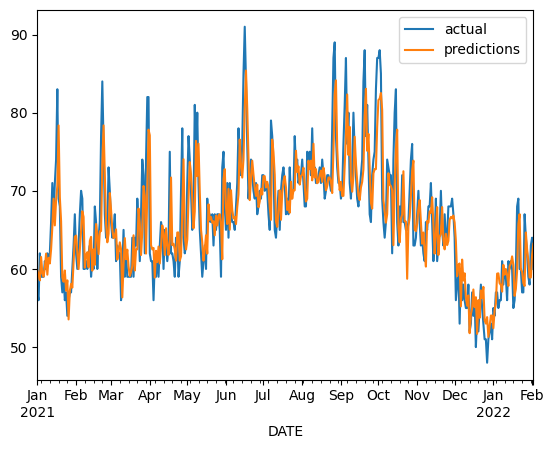

In [105]:
combined.plot()

In [106]:
# For ridge regression, coef shows the learned weight for each predictor
reg.coef_

array([-2.20730384,  0.72113834,  0.17969047])

- For each 1-unit increase in precip, the model predicts a **decrease of 2.21 units** in the next day's maximum temperature.
- For each 1-unit increase in temp_max (today’s max temperature), the model predicts an **increase of 0.72 units** in tomorrow’s max temperature.
- For each 1-unit increase in temp_min (today’s min temperature), the model predicts an **increase of about 0.18 units** in tomorrow’s max temperature.

## Additional feature engineering

In [107]:
core_weather["month_max"] = core_weather["temp_max"].rolling(30).mean()
core_weather["month_day_max"] = core_weather["month_max"] / core_weather["temp_max"]
core_weather["max_min"] = core_weather["temp_max"] / core_weather["temp_min"]

In [108]:
core_weather = core_weather.iloc[30:,:].copy()

## Predictions using a function

We create a function that simplifies training, predicting, and calculating error in a single step in order to try predictor sets and compare errors.

In [109]:
def create_predictions(predictors, core_weather, reg):
    train = core_weather.loc[:"2020-12-31"]
    test = core_weather.loc["2021-01-01":]

    reg.fit(train[predictors], train["target"])
    predictions = reg.predict(test[predictors])

    error = mean_squared_error(test["target"], predictions)
    
    combined = pd.concat([test["target"], pd.Series(predictions, index=test.index)], axis=1)
    combined.columns = ["actual", "predictions"]
    return error, combined

In [110]:
predictors = ["precip", "temp_max", "temp_min", "month_day_max", "max_min"]

# Comparing different sets of  features
error, combined = create_predictions(predictors, core_weather, reg)
error

19.907726581898878

<Axes: xlabel='DATE'>

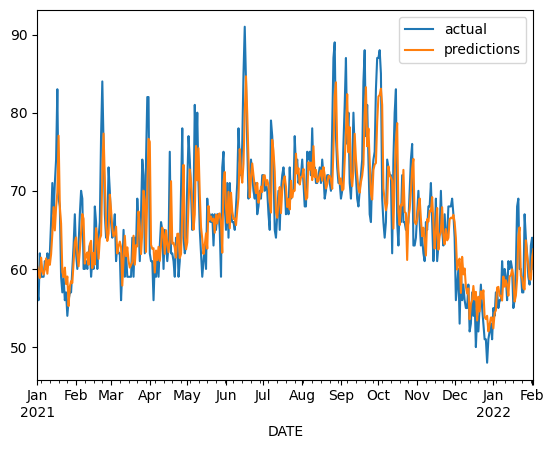

In [111]:
combined.plot()

In [113]:
core_weather["monthly_avg"] = core_weather.groupby(core_weather.index.month)["temp_max"].transform(lambda x: x.expanding().mean())
core_weather["day_of_year_avg"] = core_weather.groupby(core_weather.index.day_of_year)["temp_max"].transform(lambda x: x.expanding().mean())

In [114]:
error, combined = create_predictions(predictors + ["monthly_avg", "day_of_year_avg"], core_weather, reg)
error

19.133015869906803

In [116]:
reg.coef_

array([-1.07706522,  0.69350145,  0.04696919,  4.78060588,  0.07003167,
        0.16384976,  0.08581002])

## Correlation

Shows how each variable is linearly correlated with target (tomorrow’s max temperature).

In [117]:
core_weather.corr()["target"]

precip            -0.205325
temp_max           0.821677
temp_min           0.596089
target             1.000000
month_max          0.686918
month_day_max     -0.421342
max_min            0.045169
monthly_avg        0.689863
day_of_year_avg    0.712395
Name: target, dtype: float64

## Predictors analysis

We calculate the absolute difference (diff) between actual and predicted values, sorting in descending order highlights dates with the biggest errors.

In [118]:
combined["diff"] = (combined["actual"] - combined["predictions"]).abs()

In [119]:
combined.sort_values("diff", ascending=False).head(10)

,actual,predictions,diff
DATE,,,
2021-01-17,83.0,68.433744,14.566256
2021-04-01,62.0,75.713379,13.713379
2021-05-07,81.0,67.678091,13.321909
2021-02-21,77.0,64.141065,12.858935
2021-10-16,66.0,78.707594,12.707594
2021-02-22,84.0,71.354231,12.645769
2021-03-30,82.0,69.994973,12.005027
2021-07-07,79.0,67.323738,11.676262
2021-03-29,74.0,62.502014,11.497986


# Follow-ups (to be done later on) ...

- Predict weather for an entire week
- Using data from different weather station
- Using different models
- Create predictions using backtesting for future years